# Sentiment Analysis

_THIS NOTEBOOK DOES NOT WORK, THERE IS A BUG I CANNOT FIGURE OUT ... _

In this notebook we preprocess the tweets and then construct, train and use an LSTM for their classification. (Note: A similar notebook with lot of comments and explanations can be found [here](https://github.com/rbuerki/projects-dl/blob/master/sentiment_analysis_LSTM_movie_reviews/4-sentiment_LSTM_movie_reviews.ipynb).)

**Data Sources:**

- `data/raw/train.csv`: labelled data for approx. 7'600 tweets
- `data/raw/test.csv`: test data for approx. 3'400 tweets
- `embeddings.pkl`: learned embeddings, tensor (to use as embedding layer in classification LSTM)
- `vocab_to_int`, `int_to_vocab`, `vocab_list`, `tweets_train` , `tweets_test`: pre-processed training data

**Data Output:**

- `xxx`: ...


**Changes**

- 2020-01-10: Start notebook


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data pre-processing</a></span><ul class="toc-item"><li><span><a href="#Tokenize-tweets" data-toc-modified-id="Tokenize-tweets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tokenize tweets</a></span></li><li><span><a href="#Pad-tweets" data-toc-modified-id="Pad-tweets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pad tweets</a></span></li><li><span><a href="#Split-into-Training,-Validation,-Test" data-toc-modified-id="Split-into-Training,-Validation,-Test-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split into Training, Validation, Test</a></span></li><li><span><a href="#Create-DataLoaders-and-Batching" data-toc-modified-id="Create-DataLoaders-and-Batching-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create DataLoaders and Batching</a></span></li></ul></li><li><span><a href="#Build-Sentiment-Network-with-PyTorch" data-toc-modified-id="Build-Sentiment-Network-with-PyTorch-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build Sentiment Network with PyTorch</a></span></li><li><span><a href="#Instantiate-the-network" data-toc-modified-id="Instantiate-the-network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Instantiate the network</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Inference-on-a-test-review" data-toc-modified-id="Inference-on-a-test-review-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Inference on a test review</a></span></li></ul></li></ul></div>

## Import libraries, load data

In [1]:
from string import punctuation
from collections import Counter
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')

(None, None)

In [2]:
def load_obj(path):
    with open(path, 'rb') as f:
        print("loaded:" + path)
        return pickle.load(f)

objects_to_load = ["data/processed/vocab_to_int.pkl",
                   "data/processed/int_to_vocab.pkl",
                   "data/processed/vocab_list.pkl",
                   "data/processed/tweets_train.pkl",
                   "data/processed/tweets_test.pkl",
                   "embeddings.pkl"]

vocab_to_int, int_to_vocab, vocab_list, tweets_train, tweets_test, embeddings = \
        [load_obj(path)for path in objects_to_load]

# we also need the labels 
train_labels = pd.read_csv('data/raw/train.csv', usecols=['target']).values 
train_labels = train_labels.reshape(-1)
display(np.array(train_labels[:5]))

loaded:data/processed/vocab_to_int.pkl
loaded:data/processed/int_to_vocab.pkl
loaded:data/processed/vocab_list.pkl
loaded:data/processed/tweets_train.pkl
loaded:data/processed/tweets_test.pkl
loaded:embeddings.pkl


array([1, 1, 1, 1, 1], dtype=int64)

## Data pre-processing

The reviews are already cleaned, but we now have to

1. Encode each word with an integer. 
2. Bring the reviews to uniform length.

### Tokenize tweets

In [3]:
def tokenize(tweets, vocab_to_int=vocab_to_int):
    tweets_ints = []
    for tweet in tweets:
        tweet_int = [vocab_to_int[word] for word in tweet.split()]
        tweets_ints.append(tweet_int)

    return tweets_ints

In [4]:
tweets_ints = tokenize(tweets_train)

# Check results
assert len(tweets_ints) == len(train_labels)
print("Tokenized review:", tweets_ints[:1])

Tokenized review: [[127, 33, 6, 889, 13, 30, 5, 259, 149, 1589, 100, 53]]


### Pad tweets

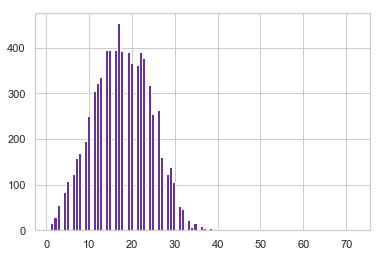

In [5]:
plt.figure()
plt.hist([len(x) for x in tweets_ints], bins=100, color='rebeccapurple');

In [6]:
def pad_features(tweets_ints, seq_length):
    ''' Return features of review_ints, where each review is left-padded with 0's 
        or truncated to the input seq_length.
    '''
       
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)
    for i, tweet in enumerate(tweets_ints):
        features[i, -len(tweet):] = np.array(tweet[:seq_length])
    
    return features

In [7]:
# Test implementation
seq_length = 40

features = pad_features(tweets_ints, seq_length=seq_length)

assert len(features)==len(tweets_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# Print first 5 features
print(features[:5,:])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   127   33    6  889   13   30    5  259  149 1589  100   53]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  200   57  237  812    1 1195]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   53 1716 1590   12    7 2108   11  669    7   33  139   29
  1717    1   58  407  260   72 2108   11  669 1375   33 1086]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  846 2840   73    5 1472  260 1375   11  101]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   45  110 1196   30
   353   32    5 1887   41  

### Split into Training, Validation, Test

**Note:** As this is a Kaggle dataset with don't have labels for the provided test data. So we have to split the training set 3-wise to create our own test data for the model evaluation.

In [8]:
split_frac = 0.8

# Split data into training, validation, and test data (features and labels, x and y)
upper_train = int(len(features) * split_frac)
upper_val = int(upper_train + (len(features) * (1-split_frac) / 2))


train_x = features[:upper_train, :]
val_x = features[upper_train : upper_val, :]
test_x = features[upper_val: , :]

train_y = train_labels[:upper_train]
val_y = train_labels[upper_train : upper_val]
test_y = train_labels[upper_val:]

# Print out the shapes of resultant feature data
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(6090, 40)
(761, 40)
(762, 40)


In [9]:
# Preporcess the kaggle test data too - we will need this in the very end

def tokenize_test(tweets, vocab_to_int=vocab_to_int):
    """Note: This function is sets all words that are not in the train vocab to <PAD>.
    May not be the very best of all options, but let's do it anyway.
    """
    
    tweets_ints = []
    for tweet in tweets:
        tweet_int = np.zeros(len(tweet.split()), dtype=int)
        for word_index, word in enumerate(tweet.split()):
            if word in vocab_to_int:
                tweet_int[word_index] = vocab_to_int[word]
            else:
                tweet_int[word_index] = 0
        tweets_ints.append(tweet_int)
        
    return tweets_ints

kaggle_ints = tokenize_test(tweets_test)
kaggle_x = pad_features(kaggle_ints, 40)

print(kaggle_x.shape)
print(kaggle_x[:2])

(3263, 40)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   45  941   10 1911  140  104]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   461   71    5  259   17 1181 2573    0  616 2006  227    1]]


### Create DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets.

This is an alternative to creating a generator function for batching our data into full batches.

In [10]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [11]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([32, 40])
Sample input: 
 tensor([[   0,    0,    0,  ...,    2,    3,    1],
        [   0,    0,    0,  ...,  664,   56, 2909],
        [   0,    0,    0,  ...,    5,  143,    5],
        ...,
        [   0,    0,    0,  ...,  599,    5,  178],
        [   0,    0,    0,  ...,    2,    3,    1],
        [   0,    0,    0,  ...,    2,    3,    1]], dtype=torch.int32)

Sample label size:  torch.Size([32])
Sample label: 
 tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0])


## Build Sentiment Network with PyTorch

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size (dimensionality reduction).
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; we return **only the last sigmoid output** as the output of this network.

**The Embedding Layer:** We will use our learned embeddings as an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) even if it may not perform well, it will help with performance: It is  inefficient to one-hot encode that many classes as are words in our vocab. So, instead of one-hot encoding, we use that layer as a lookup table.

**The LSTM Layer(s):** We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

In [12]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [13]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, 
                 hidden_dim, n_layers, embeddings, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Define all layers
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        
#         self.embed.weight = nn.Parameter(embeddings, requires_grad=False)  # hopefully ...

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
            
        embedded = self.embed(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # stack-up LSTM output
        out = self.dropout(lstm_out) 
        out = self.fc(out)
        sig_out = self.sig(out)
        
        
        # Reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # get last batch of labels only!
        
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        """
        Initializes hidden state to all zeros and move to GPU if available.
        """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

`__init__` **explanation:**
- First I have an embedding layer, which should take in the size of our vocabulary (our number of integer tokens) and produce an embedding of embedding_dim size. So, as this model trains, this is going to create and embedding lookup table that has as many rows as we have word integers, and as many columns as the embedding dimension.

- Then, I have an LSTM layer, which takes in inputs of embedding_dim size. So, it's accepting embeddings as inputs, and producing an output and hidden state of a hidden size. I am also specifying a number of layers, and a dropout value, and finally, I’m setting batch_first to True because we are using DataLoaders to batch our data like that!

- Then, the LSTM outputs are passed to a dropout layer and then a fully-connected, linear layer that will produce output_size number of outputs. And finally, I’ve defined a sigmoid layer to convert the output to a value between 0-1.


`forward` **explanation:**
- First, I'm getting the batch_size of my input x, which I’ll use for shaping my data. Then, I'm passing x through the embedding layer first, to get my embeddings as output.

- These embeddings are passed to the lstm layer, alongside a hidden state, and this returns an lstm_output and a new hidden state. Then I'm going to stack up the outputs of my LSTM to pass to my last linear layer.

- Then I keep going, passing the reshaped lstm_output to a dropout layer and my linear layer, which should return a specified number of outputs that I will pass to my sigmoid activation function.

- Finally, I want to make sure that I’m returning only the last of these sigmoid outputs for a batch of input data, so, I’m going to shape these outputs into a shape that is batch_size first. Then I'm getting the last bacth by calling `sig_out[:, -1]`.

`init_hidden` **explanation:** The hidden and cell states of an LSTM are a tuple of values and each of these is size (n_layers by batch_size, by hidden_dim). I’m initializing these hidden weights to all zeros, and moving to a gpu if available.

## Instantiate the network

Hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3


In [14]:
# Instantiate the model with hyperparams
vocab_size = len(vocab_to_int)
output_size = 1  # a sigmoid value between 0 and 1
embedding_dim = 400 
hidden_dim = 256 
n_layers = 2

embeddings = embeddings.type(torch.LongTensor)

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, embeddings)

print(net)

SentimentRNN(
  (embed): Embedding(3490, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


---
## Training

We use a kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.

We also have some data and training hyparameters:

* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [15]:
# Loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

**Note on Output, target format:** In the training loop, we are making sure that our outputs are squeezed so that they do not have an empty dimension output.squeeze() and the labels are float tensors, labels.float(). Then we perform backpropagation as usual.

In [16]:
# Training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip = 5  # gradient clipping

# Move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# Train for some number of epochs
for e in range(epochs):
    # Initialize hidden state
    h = net.init_hidden(batch_size)

    # Batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # Zero accumulated gradients
        net.zero_grad()

        # Get the output from the model
        output, h = net(inputs, h)

        # Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # Loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.IntTensor instead (while checking arguments for embedding)

---
## Testing

There are a few ways to test your network.

* **Test data performance:** First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data.

* **Inference on user-generated data:** Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts. Looking at new, user input data like this, and predicting an output label, is called **inference**.

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

### Inference on a test review

You can change this test_review to any text that you want. Read it and think: is it pos or neg? Then see if your model predicts correctly!
    
> **Exercise:** Write a `predict` function that takes in a trained net, a plain text_review, and a sequence length, and prints out a custom statement for a positive or negative review!
* You can use any functions that you've already defined or define any helper functions you want to complete `predict`, but it should just take in a trained net, a text review, and a sequence length.


In [ ]:
# Test reviews
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. \
                   This movie had bad acting and the dialogue was slow.'
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'
test_review_raph = 'I am not so shure if I can recommend this movie, it was more or less ok, \
                    but that is all I can say about it.'

In [ ]:
def predict(net, test_review, sequence_length=200):
    ''' Prints out whether a give review is predicted to be 
        positive or negative in sentiment, using a trained model.
        
        params:
        net - A trained net 
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''
    
    review_clean = ''.join([c for c in test_review.lower() if c not in punctuation])
    review_int = [vocab_to_int[word] for word in review_clean.split()]
    features = np.zeros(sequence_length, dtype=int)
    features[-len(review_int):] = np.array(review_int[:seq_length])
    features = features.reshape(1, -1)  # transform to 2D
    feature_tensor = torch.from_numpy(features)  # convert to tensor to pass into model
    print(feature_tensor.size())
    net.eval()
    
    batch_size = feature_tensor.size(0)
    h = net.init_hidden(batch_size)

    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()

    # Get the output from the model
    output, h = net(feature_tensor, h)
    pred = torch.round(output.squeeze())  # convert output probabilities to predicted class (0 or 1)
    
    
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")       

In [ ]:
# Call function
seq_length=200
predict(net, test_review_neg, seq_length)

In [ ]:
# Call function
seq_length=200
predict(net, test_review_pos, seq_length)

In [ ]:
# Call function
seq_length=200
predict(net, test_review_raph, seq_length)

---